# Матчинг товаров для интернет магазина

Я получил сырые необработанные данные интернет магазина. В них содержатся признаки в вектороной форме. 

## Задача
- необходимо разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.
- в задаче я планирую поэкспереметировать с faiss а затем применить градиентный бустинг

## Данные

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Анализ и предобработка

In [2]:
df_base = pd.read_csv("base.csv", index_col=0)
df_base.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [3]:
#df_base.info() # 72 колонки и почти 3 млн индексов, все данные в float64

In [4]:
df_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

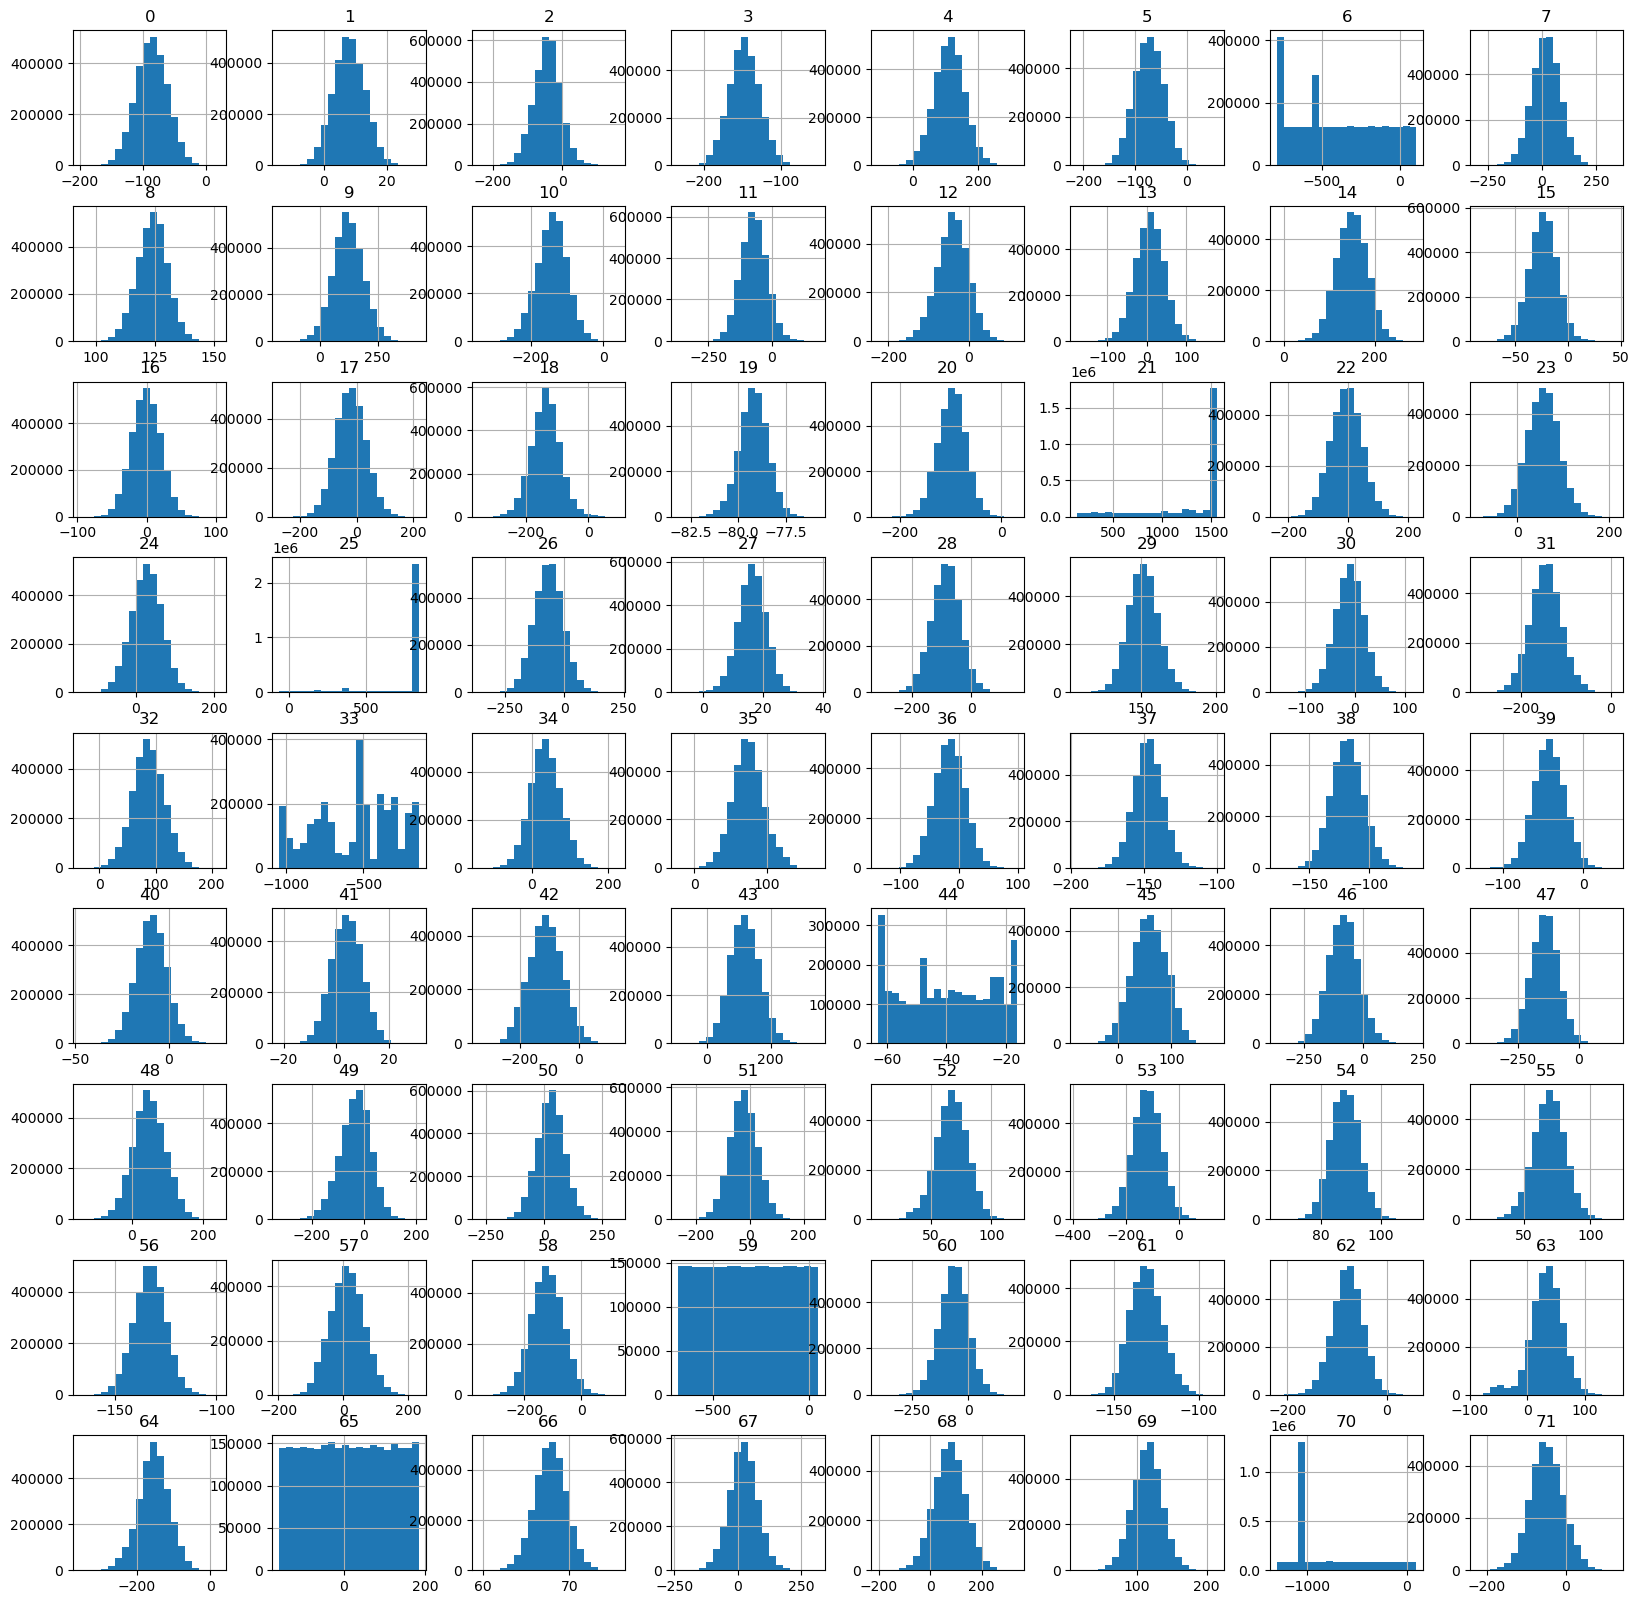

In [5]:
df_base[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']].hist(figsize=(20, 20),bins=20)
plt.show()

In [6]:
df_base.drop(['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

По гистограмме видно, что в некоторых местах графики выглядят аномально, распределение сваливается в один или несколько параметров, это может негативно сказывать на качестве оценки

Произведем нормализацию, чтобы подготовить к машинному обучению более сбалансированные данные

In [7]:
scaler = MinMaxScaler()
scaler.fit(df_base)
normalized_data = scaler.transform(df_base)

normalized_df_base = pd.DataFrame(normalized_data, columns=df_base.columns, index = df_base.index)
normalized_df_base.head(5)

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,0.381859,0.571642,0.438010,0.627640,0.757360,0.394013,0.538352,0.469686,0.590810,0.570489,...,0.544085,0.396670,0.633174,0.524604,0.534391,0.256558,0.416823,0.545929,0.500270,0.469111
1-base,0.746236,0.621351,0.424642,0.364790,0.383926,0.462948,0.413975,0.449440,0.613731,0.525732,...,0.666910,0.277394,0.366170,0.534078,0.518351,0.536499,0.469831,0.706106,0.508134,0.472803
2-base,0.657219,0.462785,0.525830,0.547477,0.603128,0.413518,0.566394,0.605642,0.562430,0.526983,...,0.484119,0.446839,0.513529,0.554319,0.387979,0.373813,0.546430,0.524094,0.506929,0.549120
3-base,0.506591,0.409390,0.379717,0.262557,0.427874,0.563436,0.417126,0.488577,0.515627,0.610959,...,0.503523,0.268199,0.534011,0.338513,0.546449,0.413110,0.387878,0.627437,0.511351,0.434949
4-base,0.573456,0.466039,0.707574,0.507794,0.261972,0.366676,0.539650,0.490865,0.475531,0.606100,...,0.485762,0.560596,0.581915,0.598124,0.514326,0.447884,0.420834,0.495083,0.599688,0.641971


In [8]:
dims = normalized_df_base.shape[1]
n_cells = 10
# how many cells
quantizer = faiss.IndexFlatL2(dims) # задаем меру близости как Евклидово расстояние
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # cоздается индекс idx_l2 с использованием quantizer, количеством измерений и количеством ячеек

Обучим индекс idx_l2 на первых 10000 строках нормализованного DataFrame

Добавляются все строки нормализованного DataFrame в индекс idx_l2.

In [9]:
idx_l2.train(np.ascontiguousarray(normalized_df_base.values[:10000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(normalized_df_base.values).astype('float32'))

Создается словарь base_index, где ключами являются индексы, а значениями - соответствующие строки из нормализованного DataFrame normalized_df_base

In [10]:
base_index = {k: v for k, v in enumerate(normalized_df_base.index.to_list())}

#del df_base

## Обучение модели

Посмотрим на тренировочную выборку

In [11]:
df_train = pd.read_csv("train.csv", index_col=0)
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


Тем же методом нормализуем данные и удалить не информативные колонки

In [12]:
targets = df_train["Target"] # отделяем целевой признак от остальных
df_train.drop(['6','21','25','33','44','59','65','70','Target'], axis=1, inplace=True)

In [13]:
normalized_data_2 = scaler.transform(df_train)

normalized_df_train = pd.DataFrame(normalized_data_2, columns=df_train.columns, index = df_train.index)
normalized_df_train.head(5)

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,0.658807,0.727132,0.493644,0.268795,0.689247,0.459069,0.528959,0.269548,0.339675,0.663879,...,0.523843,0.474509,0.410124,0.653610,0.523709,0.394650,0.488280,0.490162,0.598241,0.567688
1-query,0.505431,0.472520,0.518737,0.305621,0.532364,0.471427,0.347428,0.537368,0.522440,0.431504,...,0.683198,0.413310,0.640286,0.383957,0.534561,0.534571,0.471199,0.540482,0.577264,0.496118
2-query,0.676470,0.404911,0.309106,0.288292,0.695387,0.593633,0.422045,0.551838,0.640956,0.668386,...,0.530638,0.391246,0.600322,0.686297,0.488433,0.401095,0.458981,0.765888,0.533752,0.577331
3-query,0.686285,0.524521,0.310894,0.615888,0.470869,0.377122,0.592526,0.521926,0.692572,0.512201,...,0.400170,0.488975,0.566357,0.548152,0.551166,0.285257,0.618937,0.527970,0.515390,0.584807
4-query,0.542286,0.646666,0.451784,0.472246,0.382624,0.721862,0.540897,0.554716,0.461021,0.614379,...,0.441782,0.828226,0.540698,0.550268,0.417198,0.457753,0.502875,0.517739,0.385741,0.581283


In [14]:
#df_train.drop(['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

In [15]:
idx_l2.nprobe = 10

In [16]:
query_vectors = np.ascontiguousarray(normalized_df_train.values).astype('float32')

Ищутся ближайшие векторы в idx_l2 для query_vectors, возвращая 5 ближайших соседей и расстояния до них

In [17]:
%%time
vecs, idx = idx_l2.search(query_vectors, 5)

CPU times: total: 9h 54min 19s
Wall time: 25min 49s


In [18]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

71.072


Я проводил разные тесты с nprobe до 10 000 , а так же n_cells более 10 000, но это не приводило к положительным изменения. Решил остановиться на минимальных метриках с максимальным качеством, чтобы сэкономить время.

## Валидация модели

Проделаем те же методы преобразования для валидационной выборки

In [39]:
validation_features = pd.read_csv('validation.csv', index_col=0)
validation_targets = pd.read_csv('validation_answer.csv', index_col=0)

In [40]:
print(validation_targets.head())
validation_features.head()

                  Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [68]:
validation_targets = validation_targets['Expected'] # объект проще обрабатывать в серии дальше

In [41]:
validation_features.drop(['6','21','25','33','44','59','65','70'], axis=1, inplace=True)

In [42]:
normalized_data_3 = scaler.transform(validation_features)

normalized_valid = pd.DataFrame(normalized_data_3, columns=validation_features.columns, index = validation_features.index)
normalized_valid.head(5)

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,0.643014,0.399353,0.565720,0.588775,0.508713,0.480808,0.686804,0.333760,0.414170,0.550161,...,0.722106,0.330744,0.516681,0.582418,0.556393,0.603163,0.538405,0.580281,0.499624,0.310105
100001-query,0.659368,0.608981,0.490772,0.541940,0.517423,0.446560,0.568903,0.574622,0.377445,0.493512,...,0.487910,0.363087,0.502687,0.484982,0.489862,0.694714,0.305020,0.553557,0.541090,0.570371
100002-query,0.612232,0.226528,0.579521,0.344781,0.475086,0.550862,0.605418,0.644870,0.569977,0.320658,...,0.657412,0.542382,0.305517,0.518703,0.513505,0.506153,0.582333,0.628228,0.629993,0.440450
100003-query,0.453344,0.685001,0.623202,0.466687,0.445106,0.286414,0.439774,0.370327,0.414155,0.595900,...,0.622613,0.526692,0.510543,0.546443,0.585234,0.702019,0.468428,0.620031,0.640905,0.388371
100004-query,0.542735,0.309005,0.558703,0.340788,0.637363,0.677194,0.522900,0.604839,0.458850,0.694687,...,0.629978,0.435730,0.344788,0.552770,0.580663,0.685581,0.453382,0.659400,0.432080,0.286844


In [43]:
idx_l2.nprobe = 10

In [44]:
query_vectors = np.ascontiguousarray(normalized_valid.values).astype('float32')

In [45]:
%%time
vecs, idx = idx_l2.search(query_vectors, 5)

CPU times: total: 9h 57min 13s
Wall time: 25min 35s


In [69]:
acc = 0
for target, el in zip(validation_targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.966


Результат получили практически такой же как на тестовой выборки. Попробубуем из 5 выбранных векторов найти лучший применяя функцию минимальной потери на catboost

In [ ]:
asdasdasd

In [70]:
!pip install catboost --no-cache-dir
from catboost import Pool, CatBoostClassifier

In [ ]:
model = CatBoostClassifier()
model.fit(normalized_df_base.values, df_base.index.values)

best_neighbors = [] # выбор лучшего соседа

for i, neighbors in enumerate(idx.tolist()):
    vectors = [base_index[r] for r in neighbors]
    predictions = model.predict_proba(normalized_df_base.loc[vectors].values)
    best_idx = np.argmax(predictions[:, 1])
    best_neighbor = vectors[best_idx]
    best_neighbors.append(best_neighbor)

print(best_neighbors)